In [72]:
%matplotlib inline

In [73]:
from matplotlib import pyplot as plt 

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2 

In [3]:
%matplotlib inline

In [4]:
import pathlib

In [5]:
CWD = pathlib.Path.cwd()

In [6]:
import sys

In [7]:
import time

In [8]:
sys.path.append('../../ml4seas/')

In [9]:
import numpy as np 
import pandas as pd 
import xarray as xr

In [10]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [11]:
from NN import *

### some parameters for the model 

In [12]:
batch_size=32

In [13]:
padd = 8

In [14]:
input_shape = (180, 360, 1) # last for the number of channels 

In [15]:
resize_shape = (176, 360) # to be evenly divided by the padd

In [16]:
n_epochs = 10 # number of epochs 

### list the files 

In [17]:
dpath = pathlib.Path('../../../data/GCMs/processed/hindcasts/CDS/CMCC/T2M/')

In [18]:
lfiles = list(dpath.glob("CMCC_T2M_seasonal_anomalies_????_??.nc"))

In [19]:
lfiles.sort()

In [20]:
dset = xr.open_mfdataset(lfiles, concat_dim='time', combine='nested', parallel=True)

### selects the training set 

In [21]:
dset_train = dset.sel(time=slice('1993','2010'))

In [22]:
dset_val = dset.sel(time=slice('2011',None))

### select one step (leadtime = 3 months), and only t2m 

In [23]:
dset_train = dset_train[['t2m']].sel(step=3)

In [24]:
dset_val = dset_val[['t2m']].sel(step=3)

### concatenate all the members long the first dimension, to increase number of instances 

In [25]:
dset_train = dset_train.stack(instance=('time','member'))

In [26]:
dset_val = dset_val.stack(instance=('time','member'))

### get the repeated datetimes (will be useful to sample repeatedly in Yds)

In [27]:
rdatetimes_train = dset_train.indexes["instance"].get_level_values(0)

In [28]:
rdatetimes_val = dset_val.indexes["instance"].get_level_values(0)

### transpose to have the instances as the first dimension 

In [29]:
dset_train = dset_train.transpose('instance','lat','lon')

In [30]:
dset_val = dset_val.transpose('instance','lat','lon')

### Generate data for tensorflow 

In [31]:
data_train = XrDataGenerator(dset_train, dset_train, {'t2m':None}, 't2m', norm=True, batch_size=batch_size, mean=None, std=None, shuffle=True, load=False)

In [33]:
data_train.mean

<xarray.DataArray 't2m' (level: 1)>
array([-0.06464051], dtype=float32)
Coordinates:
    step     int64 3
  * level    (level) int64 1

In [34]:
data_train.std

<xarray.DataArray 't2m' (level: 1)>
array([1.4709691], dtype=float32)
Coordinates:
    step     int64 3
  * level    (level) int64 1

In [35]:
data_val = XrDataGenerator(dset_val, dset_val, {'t2m':None}, 't2m', norm=True, batch_size=batch_size, mean=data_train.mean, std=data_train.std, shuffle=True, load=False)

### checks the shape (should be (batch_size, (input_shape), channels)) 

In [37]:
data_train[0][0].shape

(32, 180, 360, 1)

In [38]:
data_val[0][0].shape

(32, 180, 360, 1)

### build the model 

#### encoder 

In [39]:
# Input placeholder
original = Input(shape=(180,360,1))

# Resize to have dimensions divisible by 8
resized = ResizeLayer(newsize=(176,360))(original)

# # Wrap-around in longitude for periodic boundary conditions

padded = PeriodicPadding2D(padd)(resized)

# Encoding layers
x = Conv2D(16, (3, 3), padding='same')(padded)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)

In [40]:
encoded = MaxPooling2D((2, 2), padding='same')(x)

#### decoder 

In [41]:
# Decoding layers
x = Conv2D(8, (3, 3), padding='same')(encoded)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), padding='same')(x)

# Strip the longitude wrap-around
pruned = PrunePeriodicPadding2D(padd)(decoded)

In [42]:
outsize = ResizeLayer(newsize=(180,360))(pruned)

In [43]:
autoencoder = Model(original,outsize)

In [44]:
autoencoder.summary(line_length=120)

Model: "functional_1"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_1 (InputLayer)                                  [(None, 180, 360, 1)]                           0                 
________________________________________________________________________________________________________________________
resize_layer (ResizeLayer)                            (None, 176, 360, 1)                             0                 
________________________________________________________________________________________________________________________
periodic_padding2d (PeriodicPadding2D)                (None, 192, 376, 1)                             0                 
________________________________________________________________________________________________________________________
conv2d (Co

### build the callbacks 

### checkpoint 

In [45]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./autoencoder_checkpoint.h5", save_best_only=True)

### early stopping 

In [46]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [47]:
import os

In [48]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [49]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_08_04-13_41_19'

In [50]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### compile 

In [52]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

### run 

In [54]:
history = autoencoder.fit(data_train, validation_data=data_val, epochs=n_epochs, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/10
  1/270 [..............................] - ETA: 0s - loss: 2.2805WARNING:tensorflow:From /home/nicolasf/anaconda3/envs/brohan/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
270/270 [==============================] - 369s 1s/step - loss: 2.1434 - val_loss: 1.6543
Epoch 2/10
270/270 [==============================] - 381s 1s/step - loss: 2.0988 - val_loss: 1.6049
Epoch 3/10
270/270 [==============================] - 396s 1s/step - loss: 2.0128 - val_loss: 1.5012
Epoch 4/10
270/270 [==============================] - 389s 1s/step - loss: 1.8104 - val_loss: 1.2250
Epoch 5/10
270/270 [==============================] - 392s 1s/step - loss: 1.2762 - val_loss: 0.5992
Epoch 6/10
270/270 [==============================] - 392s 1s/step - loss: 0.6109 - val_loss: 0.3515
Epoch 7/10
270/270 [=====

### save model 

In [56]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")

In [57]:
saved_model = CWD / f"saved_autoencoder_{run_id}_{n_epochs}_epochs" 

In [ ]:
keras.models.save_model(autoencoder, saved_model)

### save history file 

In [61]:
import pickle

In [62]:
saved_history = CWD / f"saved_history_{run_id}_{n_epochs}_epochs.pkl" 

In [63]:
pickle.dump(history.history, open(saved_history, "wb"))

### Some plots 

### validation data first batch 

In [98]:
data_val[0][0].shape

(32, 180, 360, 1)

### take one from the batch 

In [167]:
i = 15

In [168]:
X = data_val[0][0][i:i+1,:,:,:]

In [169]:
X.shape

(1, 180, 360, 1)

In [170]:
pred = autoencoder.predict(X)

In [171]:
pred.shape

(1, 180, 360, 1)

In [172]:
pred = pred.squeeze()

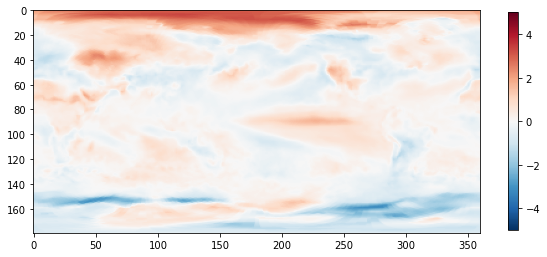

In [173]:
f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data_val[0][0][i,::-1,:,0], vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.colorbar(im, shrink=0.4)

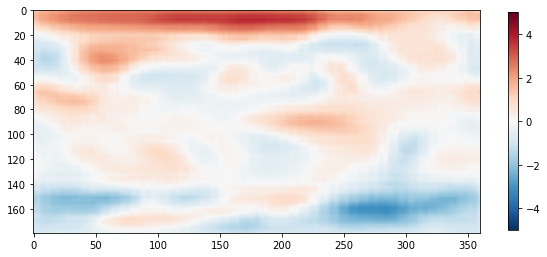

In [174]:
f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(pred[::-1,:], vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)  
plt.colorbar(im, shrink=0.4)

### loses lots of details 